<a href="https://colab.research.google.com/github/Evans200svg/Readme.md/blob/main/diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==1.2.2
!pip install xgboost

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve

)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap            #for model interpretation

df = pd.read_csv(r"/content/diabetes.csv")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# handle missing/zero values e.g bmi cannot be zero
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_features] = df[zero_features].replace(0, np.nan)
df.fillna(df.mean(), inplace=True)

In [6]:
#split features and target
x = df.drop('Outcome', axis=1)
y = df['Outcome']

In [7]:
#scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [8]:
# split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

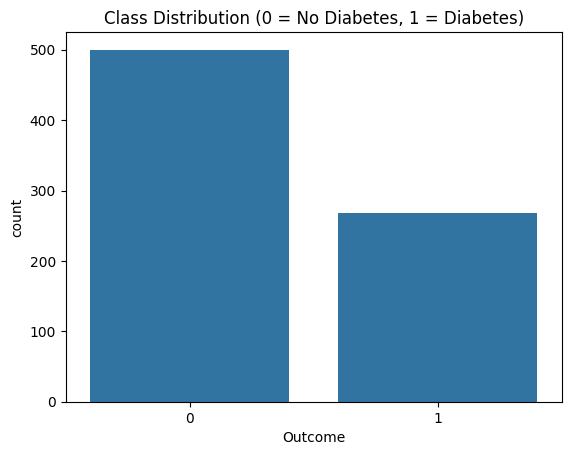

In [9]:
#plot class distribution
sns.countplot(x='Outcome', data=df)
plt.title('Class Distribution (0 = No Diabetes, 1 = Diabetes)')
plt.show()

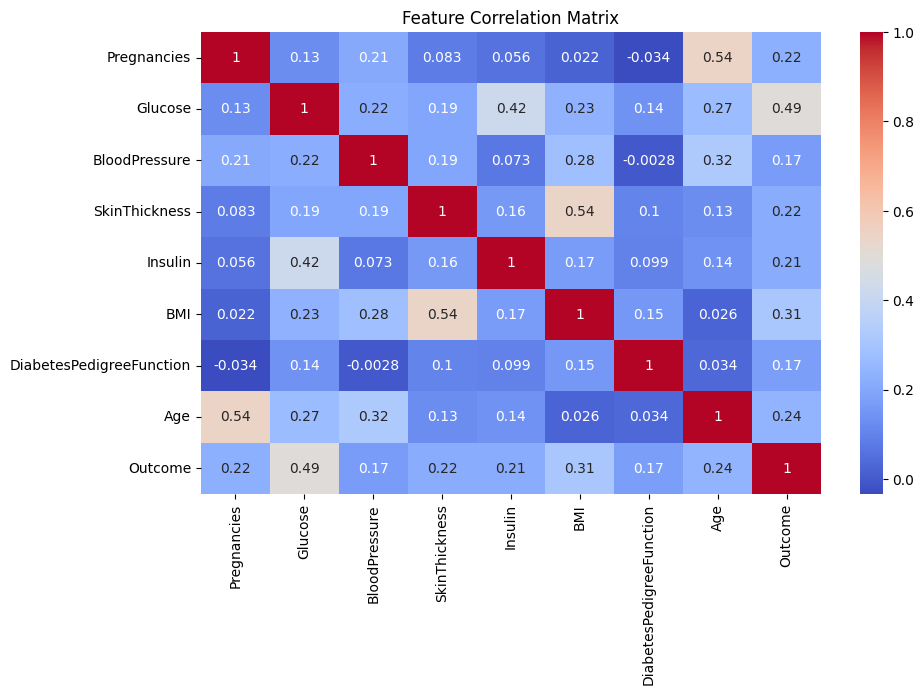

In [10]:
#correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

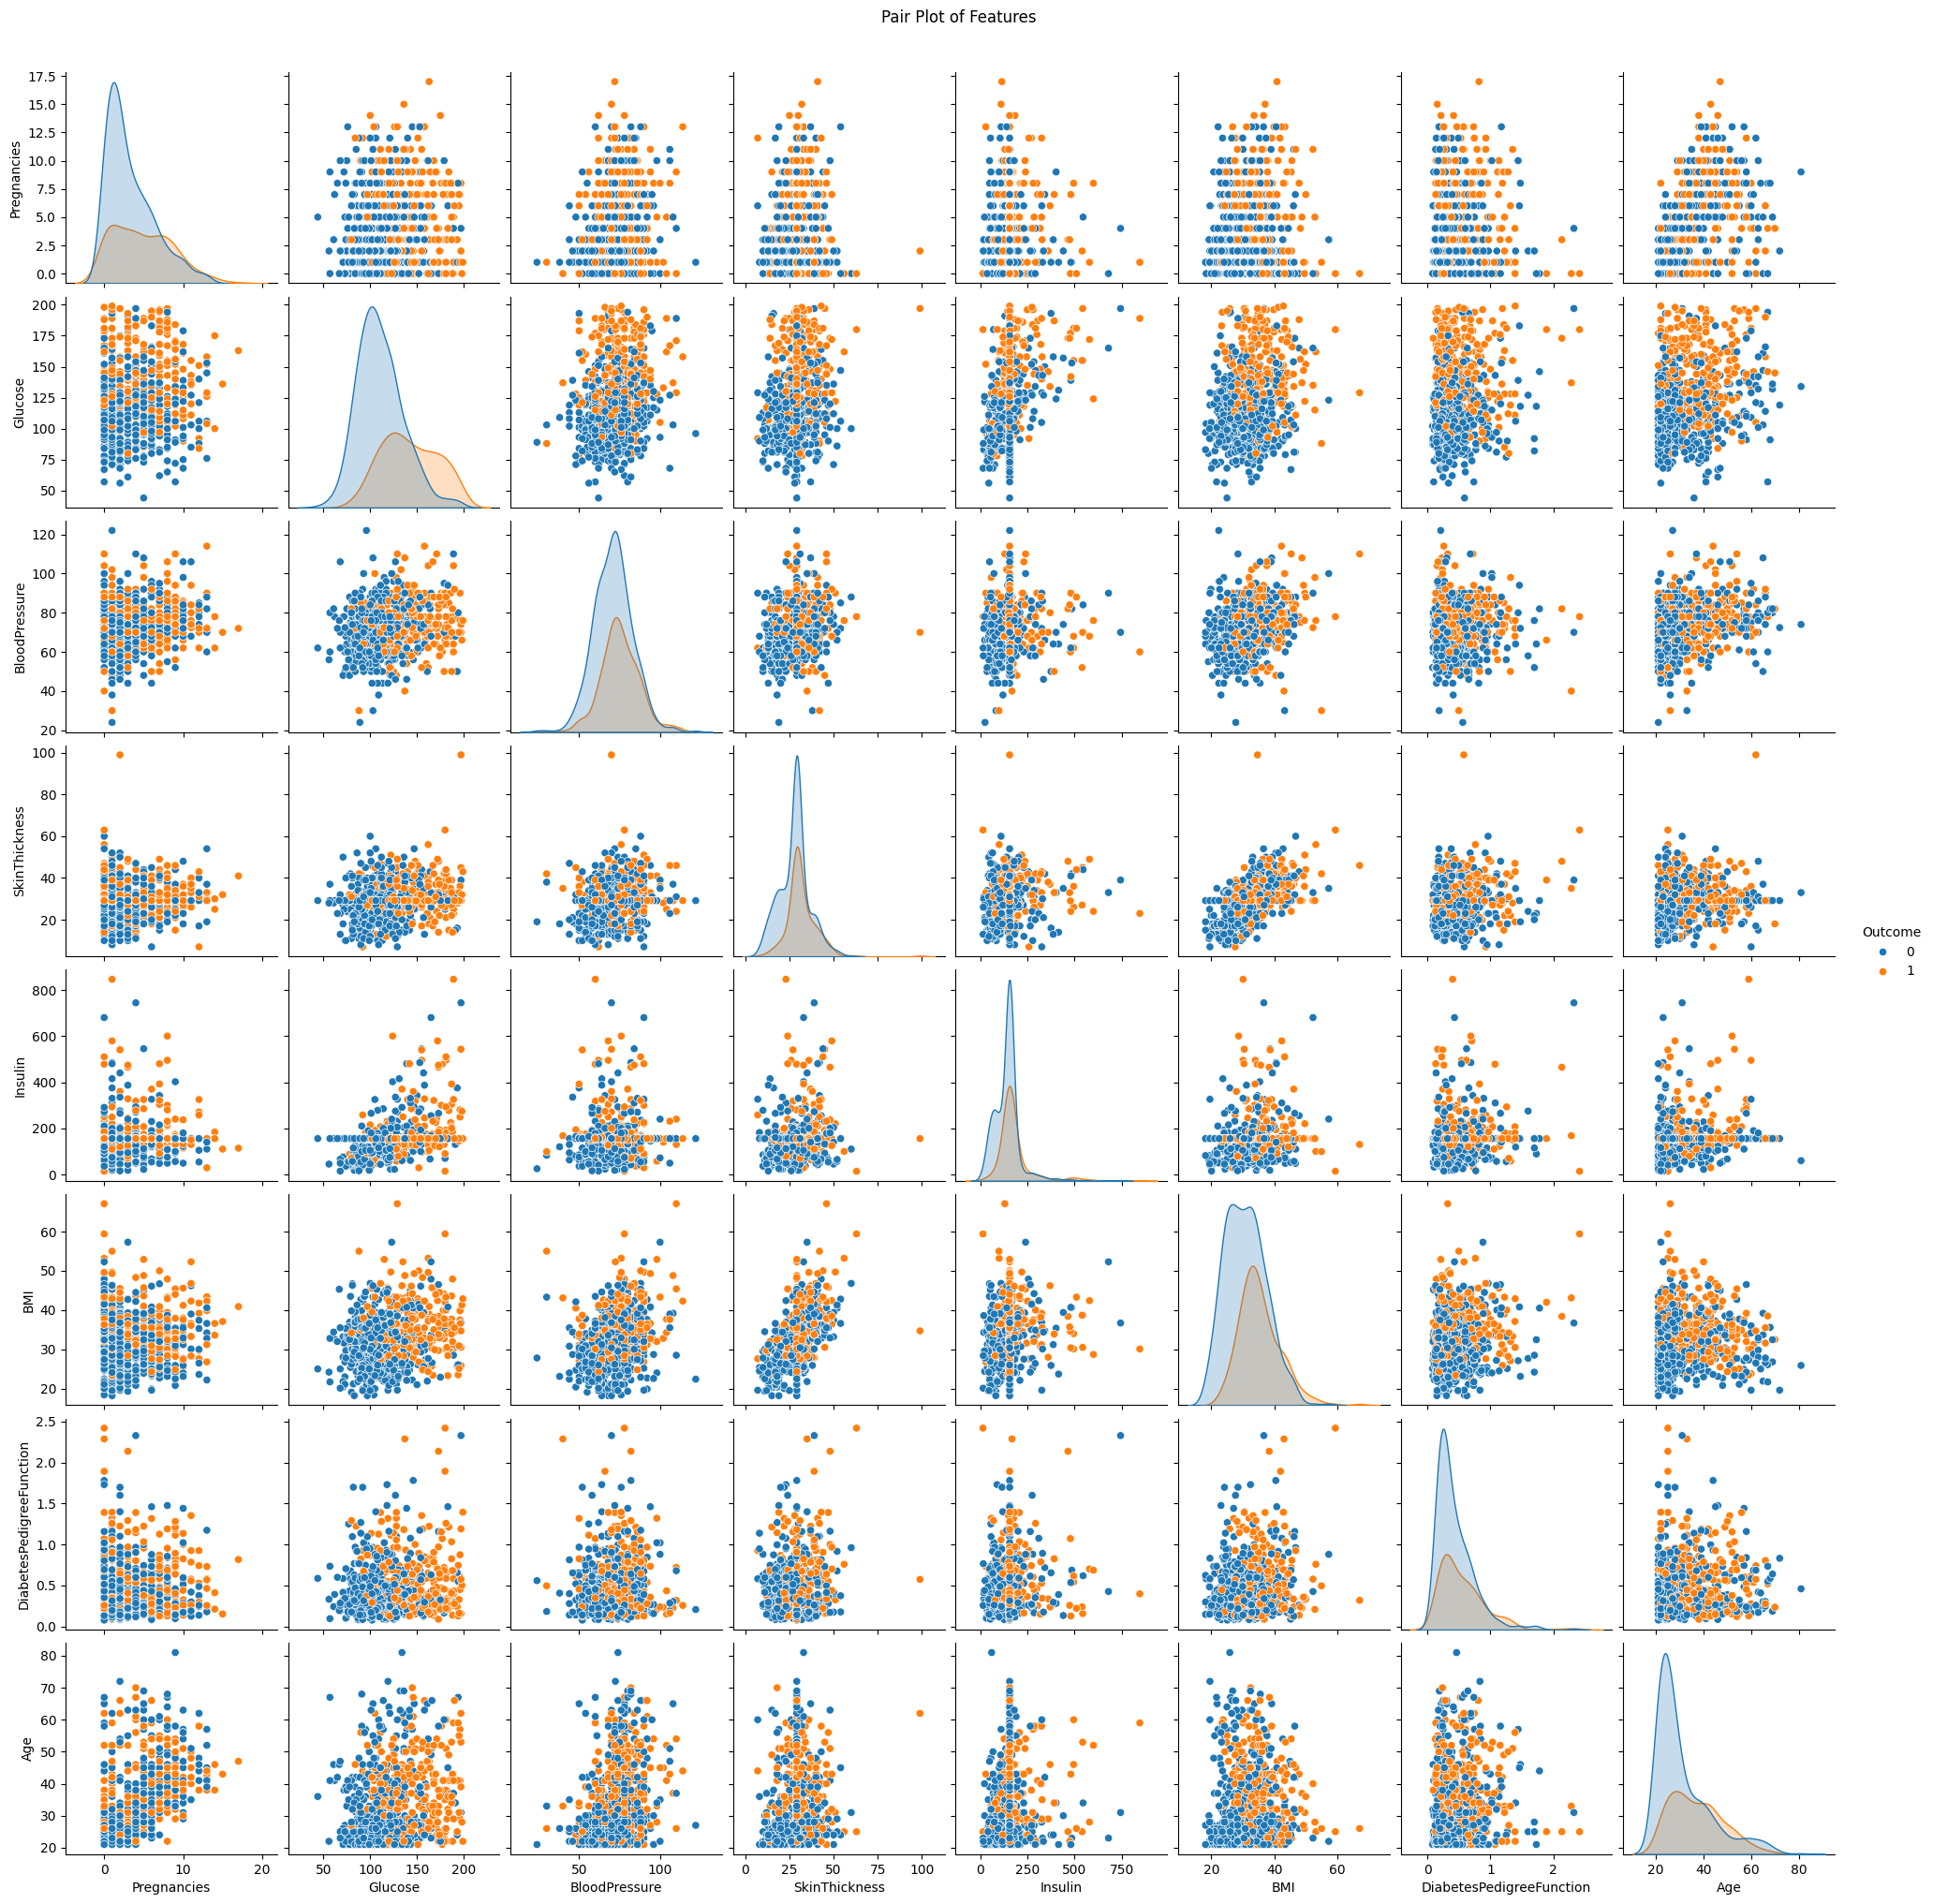

In [11]:
#pair plot for features relationship
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()

In [12]:
# initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [13]:
#train and evaluate models
results = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# store metrics
results[name] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba),
    'Classification Report': classification_report(y_test, y_pred)
}

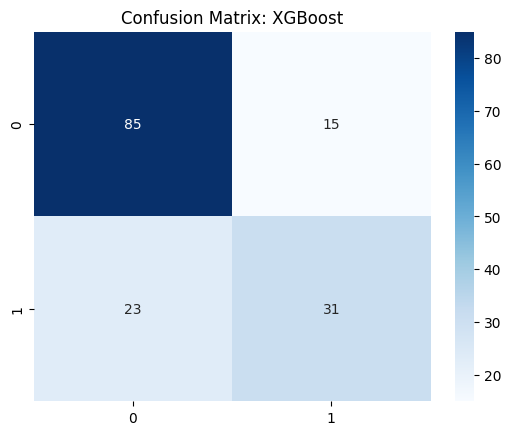

In [15]:
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {name}')
plt.show()

In [16]:
#print results
for model, metrics in results.items():
    print(f"-----: {model} -----")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.2f}")
    print(metrics['Classification Report'])

-----: XGBoost -----
Accuracy: 0.75
ROC AUC: 0.82
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.67      0.57      0.62        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



In [17]:
#define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 200]
    }

In [18]:
#grid search
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 200]},
             scoring='roc_auc')

In [19]:
#best model
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(x_test)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Tuned ROC AUC: {roc_auc_score(y_test, best_xgb.predict_proba(x_test)[:, 1]):.2f}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Tuned ROC AUC: 0.82


In [25]:
#explain prediction using shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(x_test)

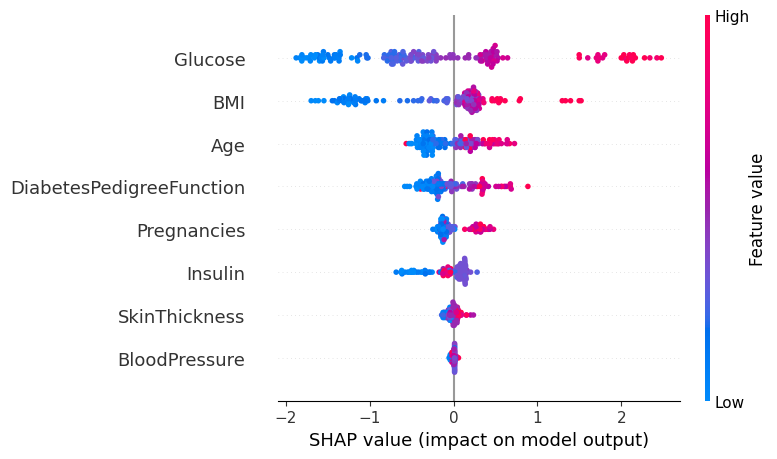

In [26]:
#summary plot
feature_names = df.drop('Outcome', axis=1).columns # Get feature names from the DataFrame
shap.summary_plot(shap_values, x_test, feature_names)

In [27]:
# force plot for a single prediction
sample_idx = 0
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    x_test[sample_idx],
    feature_names=x.columns
)

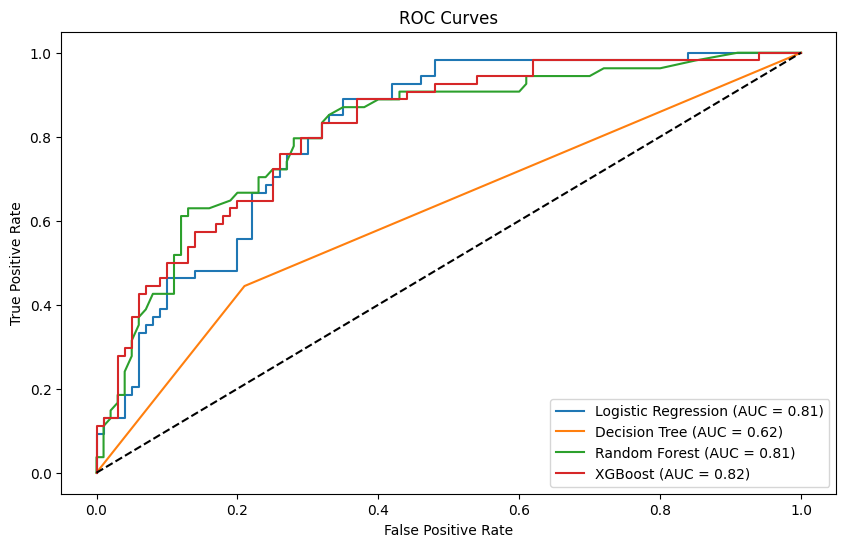

In [30]:
#plot roc curves for all models
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()